<a href="https://colab.research.google.com/github/telnarayanan/HuggingFaceTransformers/blob/main/ImageClassiciation_FoodImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
1. Get multiple classes of Images. (Specific to Indian Context - preferably)
    a. Check Google search API - python for image retrieval
        Registered with Unsplash - Image Search API
    b. Check available public datasets.
2. Load them into a Dataset and Dataloader (the correct format as expected by ViT)
3. Use Pretrained Vision Transformers from Torchvision.models
4. Make Predictions on the custom Image
5. Plot accuracy curves

"""

# 0. Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3097, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 3097 (delta 9), reused 25 (delta 8), pack-reused 3067
Receiving objects: 100% (3097/3097), 639.56 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (1761/1761), done.
Checking out files: 100% (218/218), done.


#1. Get Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Verify Data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [5]:
from os import walk
# Insert the correct path in the str
for (dirpath, dirnames, filenames) in walk("/content/drive/My Drive/Data/FoodDataset/FoodDataset/"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
    print("File name: ", filenames)

Directory path:  /content/drive/My Drive/Data/FoodDataset/FoodDataset/
Folder name:  ['dataset', 'test', 'Model']
File name:  []
Directory path:  /content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset
Folder name:  ['Dataset']
File name:  []
Directory path:  /content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset
Folder name:  ['val', 'train']
File name:  []
Directory path:  /content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/val
Folder name:  ['samosa', 'pizza', 'pav_bhaji', 'pakode', 'paani_puri', 'idli', 'kadai_paneer', 'momos', 'kaathi_rolls', 'jalebi', 'kulfi', 'masala_dosa', 'fried_rice', 'dal_makhani', 'dhokla', 'chole_bhature', 'chapati', 'chai', 'butter_naan', 'burger']
File name:  []
Directory path:  /content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/val/samosa
Folder name:  []
File name:  ['018.jpg', '085.jpg', '019.jpg', '091.jpg', '051.jpg', '157.jpg', '031.jpg', '153.jpg', '104.jpg', '068.jpg', '141.jpg', '116.jpg', '0

In [6]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/My Drive/Data/FoodDataset/")
image_path = data_path / "FoodDataset"
walk_through_dir(image_path)

There are 3 directories and 0 images in '/content/drive/My Drive/Data/FoodDataset/FoodDataset'.
There are 1 directories and 0 images in '/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset'.
There are 2 directories and 0 images in '/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset'.
There are 20 directories and 0 images in '/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/val'.
There are 0 directories and 51 images in '/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/val/samosa'.
There are 0 directories and 60 images in '/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/val/pizza'.
There are 0 directories and 61 images in '/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/val/pav_bhaji'.
There are 0 directories and 59 images in '/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/val/pakode'.
There are 0 directories and 29 images in '/content/drive/My Drive/Data/Fo

In [8]:
# Setup train and testing paths
train_dir = image_path / "dataset/Dataset/train"
test_dir = image_path / "dataset/Dataset/val"

train_dir, test_dir

(PosixPath('/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/train'),
 PosixPath('/content/drive/My Drive/Data/FoodDataset/FoodDataset/dataset/Dataset/val'))

#2. Create Datasets and DataLoaders

In [9]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [10]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f852d05cb90>,
 ['burger',
  'butter_naan',
  'chai',
  'chapati',
  'chole_bhature',
  'dal_makhani',
  'dhokla',
  'fried_rice',
  'idli',
  'jalebi',
  'kaathi_rolls',
  'kadai_paneer',
  'kulfi',
  'masala_dosa',
  'momos',
  'paani_puri',
  'pakode',
  'pav_bhaji',
  'pizza',
  'samosa'])

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

# Find why is the label's tensor is of varying size?

(torch.Size([3, 224, 224]), tensor(8))

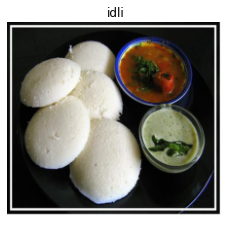

In [12]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# 3. Use Pretrained ViT from TorchVision.Models

In [13]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [16]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [17]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [18]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                                  [32, 3, 224, 224]    [32, 20]             768                  Partial
├─Conv2d (conv_proj)                                                   [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                                    [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                               [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                             [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                             [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─Encod

In [19]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 1 | train_loss: 0.9892 | train_acc: 0.7799 | test_loss: 0.5093 | test_acc: 0.8953


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch: 2 | train_loss: 0.3471 | train_acc: 0.9259 | test_loss: 0.3718 | test_acc: 0.9109


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch: 3 | train_loss: 0.2408 | train_acc: 0.9499 | test_loss: 0.3057 | test_acc: 0.9195


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 4 | train_loss: 0.1834 | train_acc: 0.9607 | test_loss: 0.2757 | test_acc: 0.9250


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch: 5 | train_loss: 0.1467 | train_acc: 0.9722 | test_loss: 0.2576 | test_acc: 0.9320


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch: 6 | train_loss: 0.1199 | train_acc: 0.9785 | test_loss: 0.2466 | test_acc: 0.9305


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 7 | train_loss: 0.1010 | train_acc: 0.9815 | test_loss: 0.2413 | test_acc: 0.9320


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch: 8 | train_loss: 0.0848 | train_acc: 0.9870 | test_loss: 0.2298 | test_acc: 0.9352


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 9 | train_loss: 0.0719 | train_acc: 0.9912 | test_loss: 0.2285 | test_acc: 0.9344


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch: 10 | train_loss: 0.0626 | train_acc: 0.9922 | test_loss: 0.2226 | test_acc: 0.9336


In [20]:
"""
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="ViT_XRay_Covid_nonCovid.pth")
                 """
torch.save(pretrained_vit, '/content/drive/My Drive/Models/IndianFoodClassification/ViT-Indianfood.pth')

In [21]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("/content/drive/My Drive/Models/IndianFoodClassification/ViT-Indianfood.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


#4. Make Predictions on a Custom Image[link text]

In [22]:
from torchvision import io
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    mode = io.image.ImageReadMode.RGB
    target_image = torchvision.io.read_image(str(image_path),mode).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

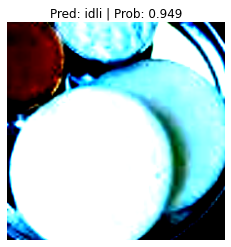

In [30]:
import requests

# Import function to make predictions on images and plot them 


# setup custom image path

#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/NORMAL(110).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/NORMAL(143).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/XRay/XRayExtract/Test/non_COVID/NORMAL(64).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/XRay/XRayExtract/Test/COVID/COVID-19 (353).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/COVID-19 (353).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/COVID-19 (439).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/COVID-19 (609).jpg'


#custom_image_path2 = '/content/drive/My Drive/Data/FoodDataset/FoodDataset/test/burger/download (1).jpg'
custom_image_path2 = '/content/drive/My Drive/Data/FoodDataset/FoodDataset/test/idli/download (1).jpg'
#custom_image_path = '/content/drive/My Drive/Data/FoodDataset/FoodDataset/test/butter_naan/'

"""
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/My Drive/Data/FoodDataset/FoodDataset/test")
image_path = data_path / "burger"
walk_through_dir(image_path)
"""

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path2,
                    class_names=class_names,
                    transform=pretrained_vit_transforms)

                    

# 5. Deploy the Model in Gradio - mrdbourke's tutorial for MLOps